# Import Libraries

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

# Load Dataset

In [15]:
df = pd.read_csv("/kaggle/input/sample-data/synthetic_ocpp_sample.csv")
df.shape

(43200, 23)

In [16]:
df['label'].value_counts()

label
0    38971
1     4229
Name: count, dtype: int64

# Basic EDA

In [17]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["month_year"] = df["timestamp"].dt.to_period("M").astype(str)

/tmp/ipykernel_36/2667552155.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month_year"] = df["timestamp"].dt.to_period("M").astype(str)


In [18]:
# Count labels grouped by month
label_counts = df.groupby(["month_year", "label"]).size().unstack(fill_value=0)

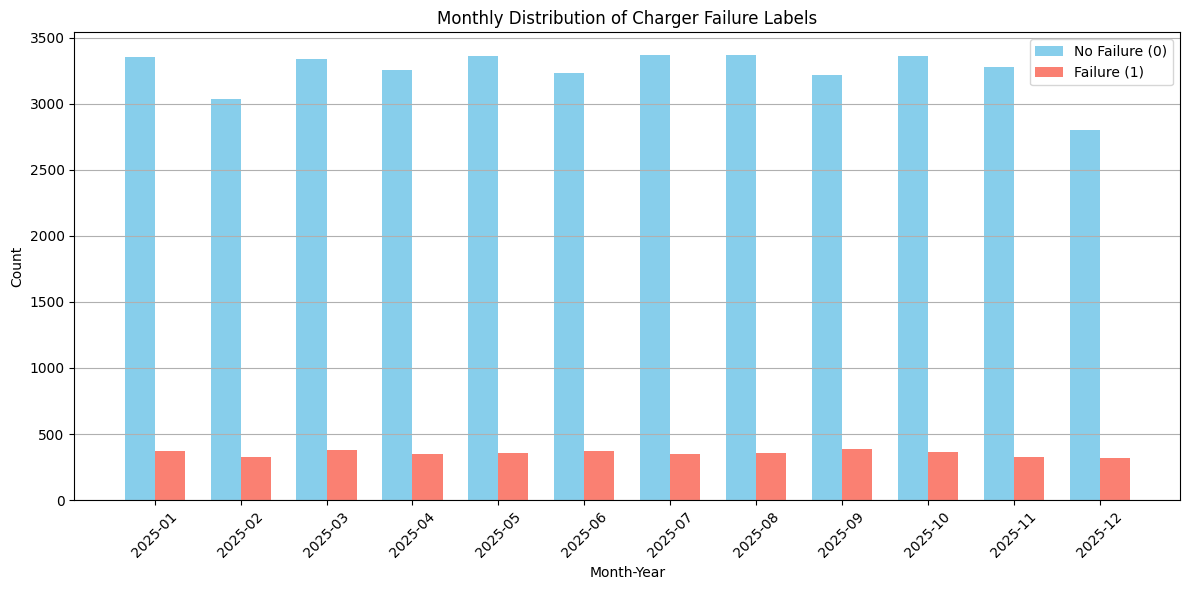

In [19]:
# Prepare x-axis
months = label_counts.index.tolist()
x = np.arange(len(months))  # label locations
width = 0.35  # bar width

# Create plot
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, label_counts[0], width, label='No Failure (0)', color='skyblue')
bars2 = ax.bar(x + width/2, label_counts[1], width, label='Failure (1)', color='salmon')

# Labels and aesthetics
ax.set_title("Monthly Distribution of Charger Failure Labels")
ax.set_xlabel("Month-Year")
ax.set_ylabel("Count")
ax.set_xticks(x)
ax.set_xticklabels(months, rotation=45)
ax.legend()
ax.grid(axis="y")
plt.tight_layout()
plt.show()

# Model Building - XGBoost

## Train-test data preparation

In [20]:
cols_to_drop = ['timestamp', 'charger_id', 'label', 'month_year']

# Features & Target
X = df.drop(columns=cols_to_drop)
y = df["label"]

In [21]:
# Use a smaller sample for faster training
X_sample, _, y_sample, _ = train_test_split(X, y, 
                                            train_size=20000, 
                                            stratify=y, random_state=42)

In [22]:
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_sample)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_sample, 
    test_size=0.2, stratify=y_sample, random_state=42
)

> `stratify=y_sample` tells `train_test_split` to preserve the original class distribution of the labels (y) in both the train and test sets.

> with `stratify=y_sample`, we ensure
  > | Set      | Label=0 (%) | Label=1 (%) |
| -------- | ----------- | ----------- |
| Original | \~90%       | \~10%       |
| Train    | \~90%       | \~10%       |
| Test     | \~90%       | \~10%       |
  

## Model training

In [23]:
# Train XGBoost model (light config)
xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    use_label_encoder=False,
    max_depth=4,
    n_estimators=50,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=50,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

## Evaluation

In [24]:
# Predictions and Evaluation
y_pred = xgb_clf.predict(X_test)
y_proba = xgb_clf.predict_proba(X_test)[:, 1]

# Metrics
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

Confusion Matrix:
 [[3608    0]
 [ 120  272]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      3608
           1       1.00      0.69      0.82       392

    accuracy                           0.97      4000
   macro avg       0.98      0.85      0.90      4000
weighted avg       0.97      0.97      0.97      4000

ROC-AUC Score: 0.8556283655369021


# Model Building - LightGBM

## Model training

In [25]:
lgbm_clf = LGBMClassifier(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    verbosity=-1
)

## Evaluation - Stacked model

> - sklearn's `StackingClassifier` does:
>   - Train base learners: xgb_clf, lgbm_clf on the original training set.
>   - Use k-fold cross-validation (cv=5):
>     - For each fold, it:
>     - Trains base learners on k-1 folds.
>     - Predicts probabilities for the held-out fold.
>     - This gives out-of-fold predictions from each base model → used as new features.
>   - Train meta-learner (LogisticRegression):
>     - On the out-of-fold predictions from base models.
>     - Learns to combine the base models.

In [26]:
# Define stacking ensemble
stack_model = StackingClassifier(
    estimators=[('xgb', xgb_clf), 
                ('lgbm', lgbm_clf)],
    final_estimator=LogisticRegression(),
    cv=5
)

# Train ensemble
stack_model.fit(X_train, y_train)

# Evaluate
y_pred = stack_model.predict(X_test)
y_proba = stack_model.predict_proba(X_test)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

Confusion Matrix:
 [[3608    0]
 [ 120  272]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      3608
           1       1.00      0.69      0.82       392

    accuracy                           0.97      4000
   macro avg       0.98      0.85      0.90      4000
weighted avg       0.97      0.97      0.97      4000

ROC-AUC Score: 0.8603252692429522


# Post-analysis

## Prediction confidence

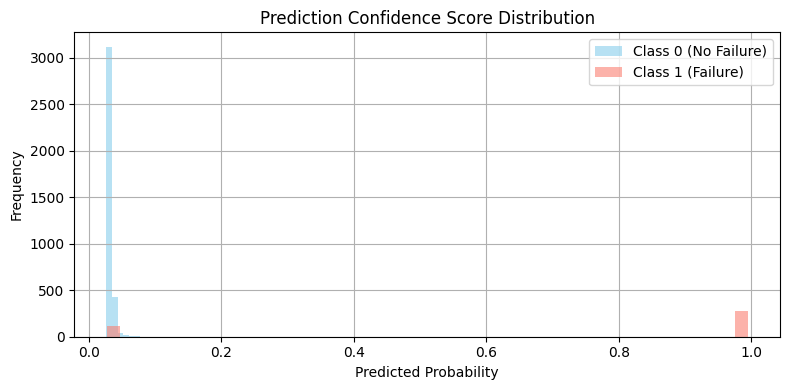

In [27]:
# Predict probabilities using the trained stacked model
y_proba = stack_model.predict_proba(X_test)[:, 1]

# Plot histogram
plt.figure(figsize=(8, 4))
plt.hist(y_proba[y_test == 0], bins=50, alpha=0.6, label="Class 0 (No Failure)", color='skyblue')
plt.hist(y_proba[y_test == 1], bins=50, alpha=0.6, label="Class 1 (Failure)", color='salmon')
plt.title("Prediction Confidence Score Distribution")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Tuning prediction threshold

In [28]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

thresholds = np.arange(0.1, 0.91, 0.05)
results = []

for threshold in thresholds:
    preds = (y_proba >= threshold).astype(int)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    results.append((threshold, precision, recall, f1))

# Convert to DataFrame for easy viewing
results_df = pd.DataFrame(results, columns=["Threshold", "Precision", "Recall", "F1 Score"])
print(results_df)

    Threshold  Precision    Recall  F1 Score
0        0.10   0.996337  0.693878  0.818045
1        0.15   0.996337  0.693878  0.818045
2        0.20   0.996337  0.693878  0.818045
3        0.25   0.996337  0.693878  0.818045
4        0.30   0.996337  0.693878  0.818045
5        0.35   0.996337  0.693878  0.818045
6        0.40   0.996337  0.693878  0.818045
7        0.45   0.996337  0.693878  0.818045
8        0.50   1.000000  0.693878  0.819277
9        0.55   1.000000  0.693878  0.819277
10       0.60   1.000000  0.693878  0.819277
11       0.65   1.000000  0.693878  0.819277
12       0.70   1.000000  0.693878  0.819277
13       0.75   1.000000  0.693878  0.819277
14       0.80   1.000000  0.693878  0.819277
15       0.85   1.000000  0.693878  0.819277
16       0.90   1.000000  0.693878  0.819277
